# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Machine Learning/MP3/NIR_Data.xlsx')
print(df.head())

                    Sample ID  Unnamed: 1  11988.51   11980.8  11973.08  \
0  3001RanBioMixMalarenergi.0           1  0.430391  0.430351  0.430570   
1  3001RanBioMixMalarenergi.1           2  0.418378  0.418387  0.418783   
2  3001RanBioMixMalarenergi.2           3  0.446782  0.446930  0.446840   
3  3001RanBioMixMalarenergi.3           4  0.434038  0.433805  0.433692   
4  3001RanBioMixMalarenergi.4           5  0.451491  0.451441  0.451692   

   11965.37  11957.66  11949.94  11942.23  11934.51  ...  4057.888  4050.173  \
0  0.430974  0.431129  0.430807  0.430425  0.430264  ...  1.042346  1.052940   
1  0.418983  0.418721  0.418339  0.417951  0.417494  ...  1.017335  1.027128   
2  0.446419  0.446009  0.445715  0.445539  0.445537  ...  1.053265  1.061849   
3  0.433850  0.433912  0.433757  0.433515  0.433327  ...  1.020629  1.029372   
4  0.451816  0.451755  0.451595  0.451293  0.451114  ...  1.013404  1.023107   

   4042.459  4034.744   4027.03  4019.315  4011.601  4003.886  3996.

# Data Preprocessing





##1.   Removing Outliers and unnecessary data

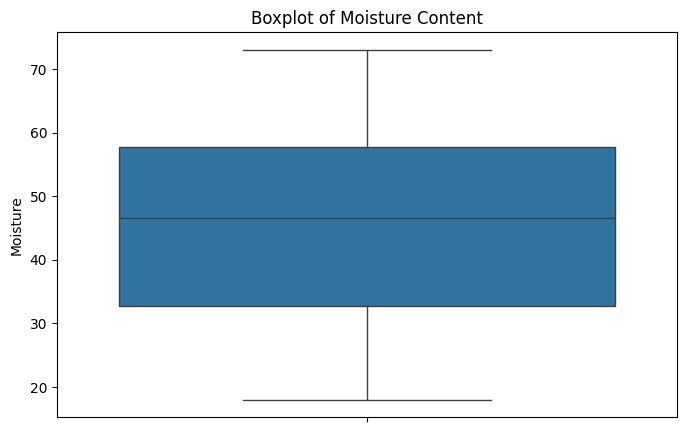

(np.int64(0),
 count    773.000000
 mean      45.923968
 std       14.438512
 min       17.981283
 25%       32.701132
 50%       46.633770
 75%       57.791259
 max       73.066950
 Name: Moisture, dtype: float64,
 np.int64(0))

In [ ]:
# Drop unnecessary columns
df_cleaned = df.drop(columns=['Sample ID', 'Unnamed: 1'])

# Check for missing values
missing_values = df_cleaned.isnull().sum().sum()

# Check for outliers in Moisture using boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_cleaned["Moisture"])
plt.title("Boxplot of Moisture Content")
plt.show()

# Summary statistics for Moisture
moisture_stats = df_cleaned["Moisture"].describe()

# Check for outliers in spectral data using z-score method
z_scores = np.abs((df_cleaned.iloc[:, :-1] - df_cleaned.iloc[:, :-1].mean()) / df_cleaned.iloc[:, :-1].std())
outlier_counts = (z_scores > 3).sum().sum()  # Count values with z-score > 3

# Display results
missing_values, moisture_stats, outlier_counts

##2.   Savitzky-Golay Filtering




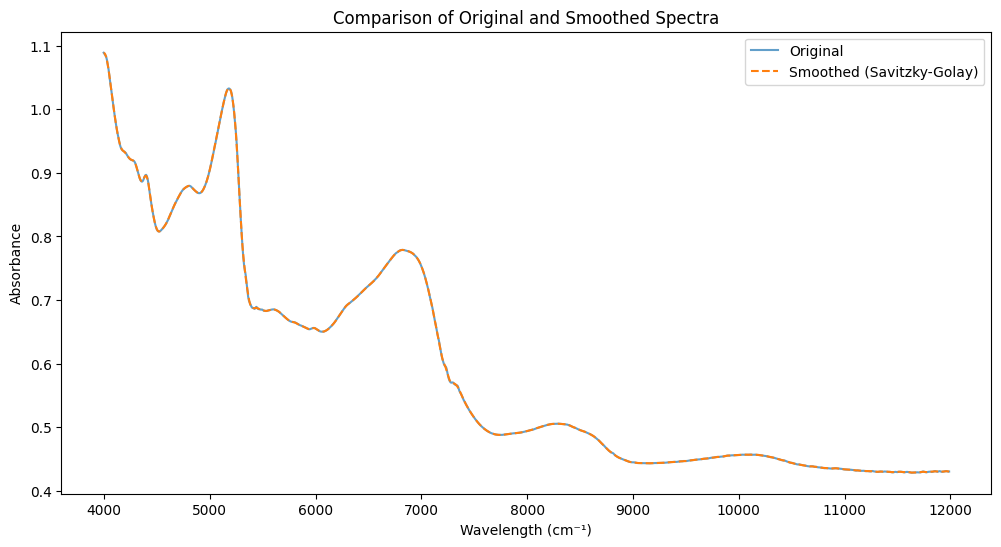

In [ ]:
# Apply Savitzky-Golay filtering to smooth spectral data (excluding the Moisture column)
filtered_spectra = savgol_filter(df_cleaned.iloc[:, :-1], window_length=11, polyorder=3, axis=1)

# Convert back to DataFrame
df_filtered = pd.DataFrame(filtered_spectra, columns=df_cleaned.columns[:-1])

# Add the Moisture column back
df_filtered["Moisture"] = df_cleaned["Moisture"]

# Plot a few original vs smoothed spectra for comparison
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.columns[:-1], df_cleaned.iloc[0, :-1], label="Original", alpha=0.7)
plt.plot(df_cleaned.columns[:-1], df_filtered.iloc[0, :-1], label="Smoothed (Savitzky-Golay)", linestyle="dashed")
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance")
plt.title("Comparison of Original and Smoothed Spectra")
plt.legend()
plt.show()

##3.   Baseline Correction, Standard Normal Variate (SNV) & Normalization



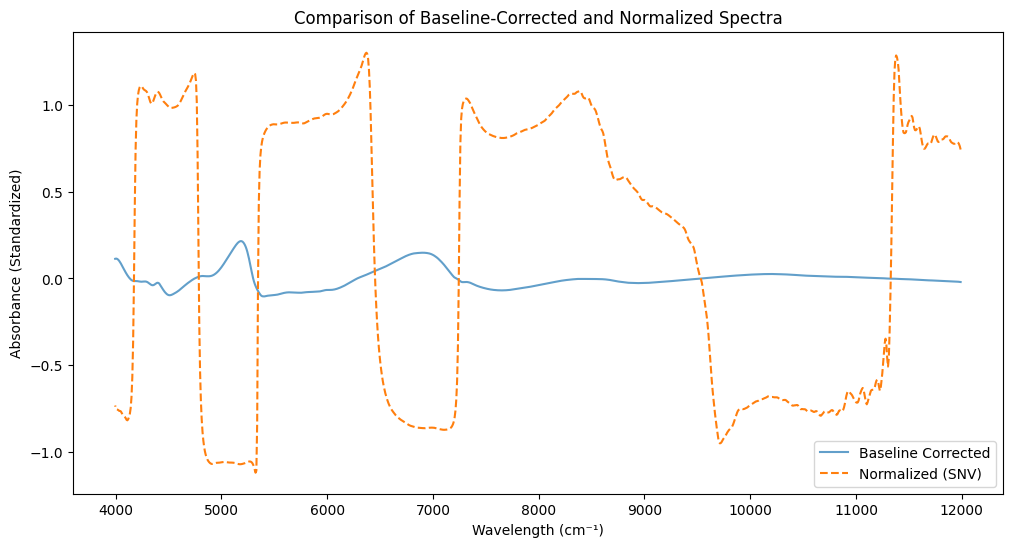

In [ ]:
# Alternative Baseline Correction: Polynomial Fitting (3rd Degree)
def polynomial_baseline_correction(y, degree=3):
    """Perform baseline correction using polynomial fitting."""
    x = np.arange(len(y))
    coeffs = np.polyfit(x, y, degree)
    baseline = np.polyval(coeffs, x)
    return y - baseline

# Apply baseline correction using polynomial fitting
baseline_corrected = np.apply_along_axis(polynomial_baseline_correction, axis=1, arr=df_filtered.iloc[:, :-1].values)

# Convert back to DataFrame
df_corrected = pd.DataFrame(baseline_corrected, columns=df_filtered.columns[:-1])
df_corrected["Moisture"] = df_filtered["Moisture"]

# Apply Standard Normal Variate (SNV) Normalization
scaler = StandardScaler()
normalized_spectra = scaler.fit_transform(df_corrected.iloc[:, :-1])

# Convert to DataFrame
df_normalized = pd.DataFrame(normalized_spectra, columns=df_corrected.columns[:-1])
df_normalized["Moisture"] = df_corrected["Moisture"]

# Plot a sample before and after normalization
plt.figure(figsize=(12, 6))
plt.plot(df_corrected.columns[:-1], df_corrected.iloc[0, :-1], label="Baseline Corrected", alpha=0.7)
plt.plot(df_corrected.columns[:-1], df_normalized.iloc[0, :-1], label="Normalized (SNV)", linestyle="dashed")
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance (Standardized)")
plt.title("Comparison of Baseline-Corrected and Normalized Spectra")
plt.legend()
plt.show()

# Feature (Wavelength) Selection

In [ ]:
# Define features (X) and target (y)
X = df_normalized.iloc[:, :-1].values
y = df_normalized["Moisture"].values

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate models
def evaluate_model(model, X, y, cv):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r2, rmse

# Perform feature selection using PLS Regression Coefficients
pls = PLSRegression(n_components=10)
pls.fit(X, y)
pls_coefficients = np.abs(pls.coef_).flatten()

# Select top N important wavelengths based on coefficient magnitudes
N = 50  # Number of top wavelengths to keep
top_indices = np.argsort(pls_coefficients)[-N:]  # Get indices of top N coefficients

# Reduce dataset to selected wavelengths
X_selected = X[:, top_indices]

# Model Training
###1.   PLS (Partial Least Squares)
###2.   SVR (Support Vector Regression)
###3.   ANN (Artificial Neural Network)



In [ ]:
# 1. PLS Regression with Selected Features
pls_selected = PLSRegression(n_components=10)
pls_selected.fit(X_selected, y)
r2_pls, rmse_pls = evaluate_model(pls_selected, X_selected, y, cv)

# 2. Support Vector Regression (SVR) with Selected Features
svr = SVR(kernel="rbf", C=10, gamma="scale")
svr.fit(X_selected, y)
r2_svr, rmse_svr = evaluate_model(svr, X_selected, y, cv)

# 3. Artificial Neural Network (MLPRegressor) with Selected Features
ann = MLPRegressor(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=2000, random_state=42)
ann.fit(X_selected, y)
r2_ann, rmse_ann = evaluate_model(ann, X_selected, y, cv)

# Compile results
results = pd.DataFrame({
    "Model": ["PLS Regression", "SVR", "ANN"],
    "R² Score": [r2_pls, r2_svr, r2_ann],
    "RMSE": [rmse_pls, rmse_svr, rmse_ann]
})

# Display results
print(results)

            Model  R² Score      RMSE
0  PLS Regression  0.954858  3.065701
1             SVR  0.956420  3.012191
2             ANN  0.949110  3.255051


# Cross-Validation Comparison

<ipython-input-42-0b719faf0605>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="RMSE", data=cv_results_df, palette="coolwarm")


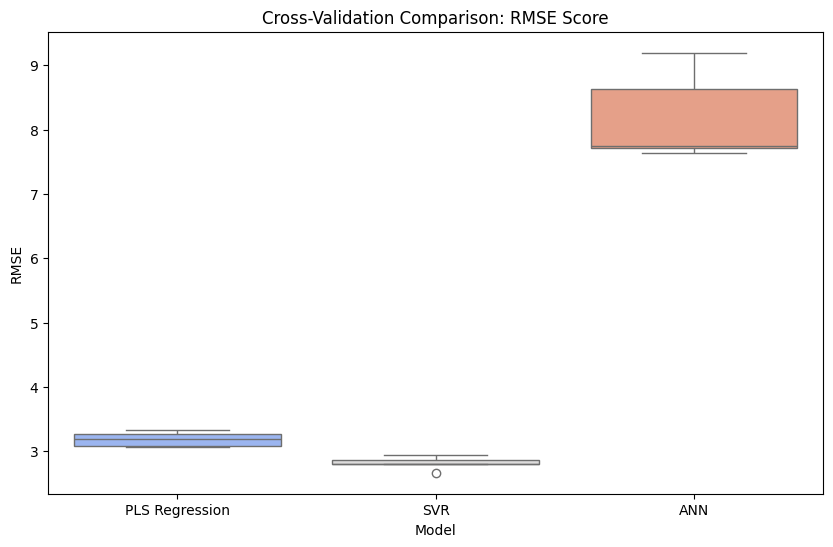

            Model      RMSE          
                       mean       std
0             ANN  8.185332  0.696994
1  PLS Regression  3.188163  0.116932
2             SVR  2.815482  0.099446


In [ ]:
# Perform cross-validation and collect RMSE scores
models = {"PLS Regression": pls, "SVR": svr, "ANN": ann}
cv_results = []

for model_name, model in models.items():
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))
    for fold, rmse in enumerate(rmse_scores, 1):
        cv_results.append({"Model": model_name, "Fold": fold, "RMSE": rmse})

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Plot Boxplot for RMSE Scores
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="RMSE", data=cv_results_df, palette="coolwarm")
plt.title("Cross-Validation Comparison: RMSE Score")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

# Compute mean and standard deviation for RMSE
summary_stats = cv_results_df.groupby("Model")[["RMSE"]].agg(["mean", "std"]).reset_index()

# Display Summary Statistics
print(summary_stats)

# Wavelength Importance

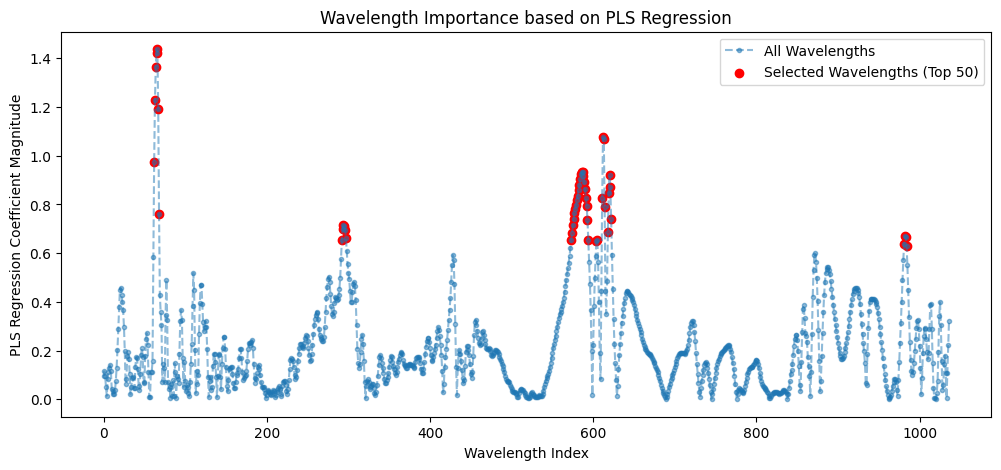

In [ ]:
# Plot the selected wavelengths based on PLS importance
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(pls_coefficients)), pls_coefficients, marker="o", markersize=3, linestyle="dashed", alpha=0.5, label="All Wavelengths")
plt.scatter(top_indices, pls_coefficients[top_indices], color="red", label="Selected Wavelengths (Top 50)")
plt.xlabel("Wavelength Index")
plt.ylabel("PLS Regression Coefficient Magnitude")
plt.title("Wavelength Importance based on PLS Regression")
plt.legend()
plt.show()

# Model Performance Comparison

###1.   Scatter Plot: Predicted vd Actual Moisture




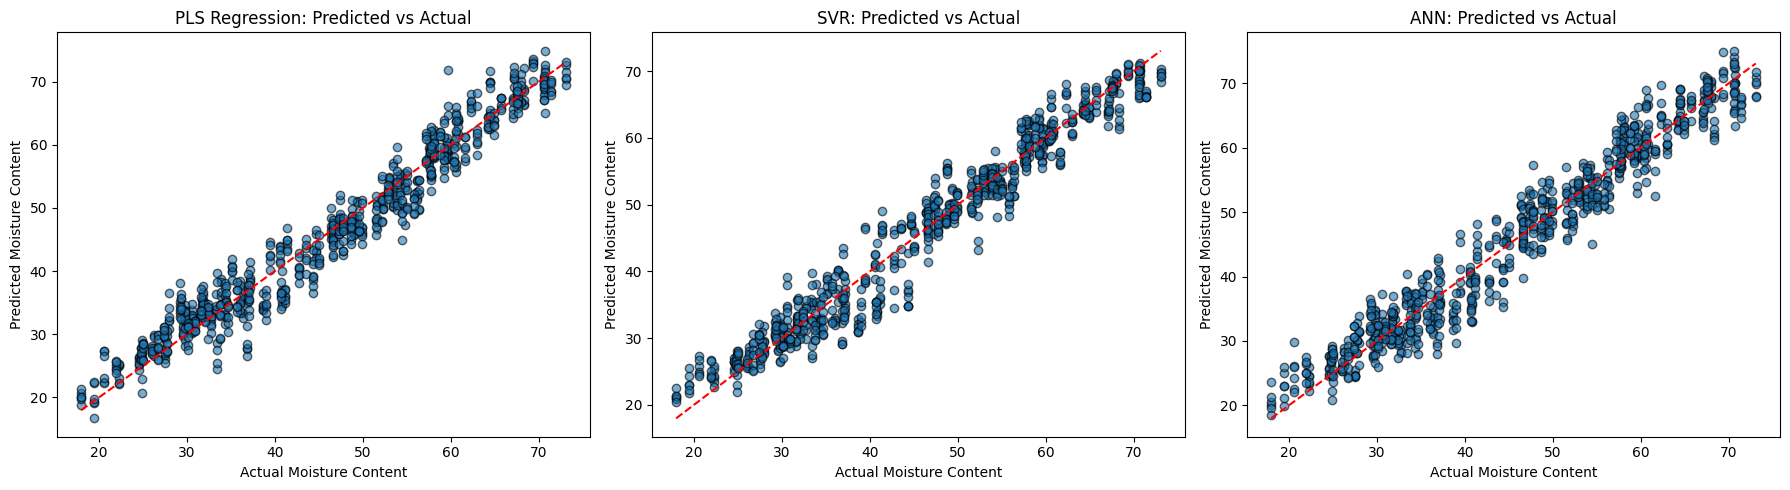

In [ ]:
# Generate predicted values for each model
y_pred_pls = cross_val_predict(pls_selected, X_selected, y, cv=cv)
y_pred_svr = cross_val_predict(svr, X_selected, y, cv=cv)
y_pred_ann = cross_val_predict(ann, X_selected, y, cv=cv)

# Scatter plot: Predicted vs Actual Moisture Content
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = ["PLS Regression", "SVR", "ANN"]
predictions = [y_pred_pls, y_pred_svr, y_pred_ann]

for ax, model, y_pred in zip(axes, models, predictions):
    ax.scatter(y, y_pred, alpha=0.6, edgecolors="k")
    ax.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="dashed")  # Ideal fit line
    ax.set_xlabel("Actual Moisture Content")
    ax.set_ylabel("Predicted Moisture Content")
    ax.set_title(f"{model}: Predicted vs Actual")

plt.tight_layout()
plt.show()

###2.   Residual Plots



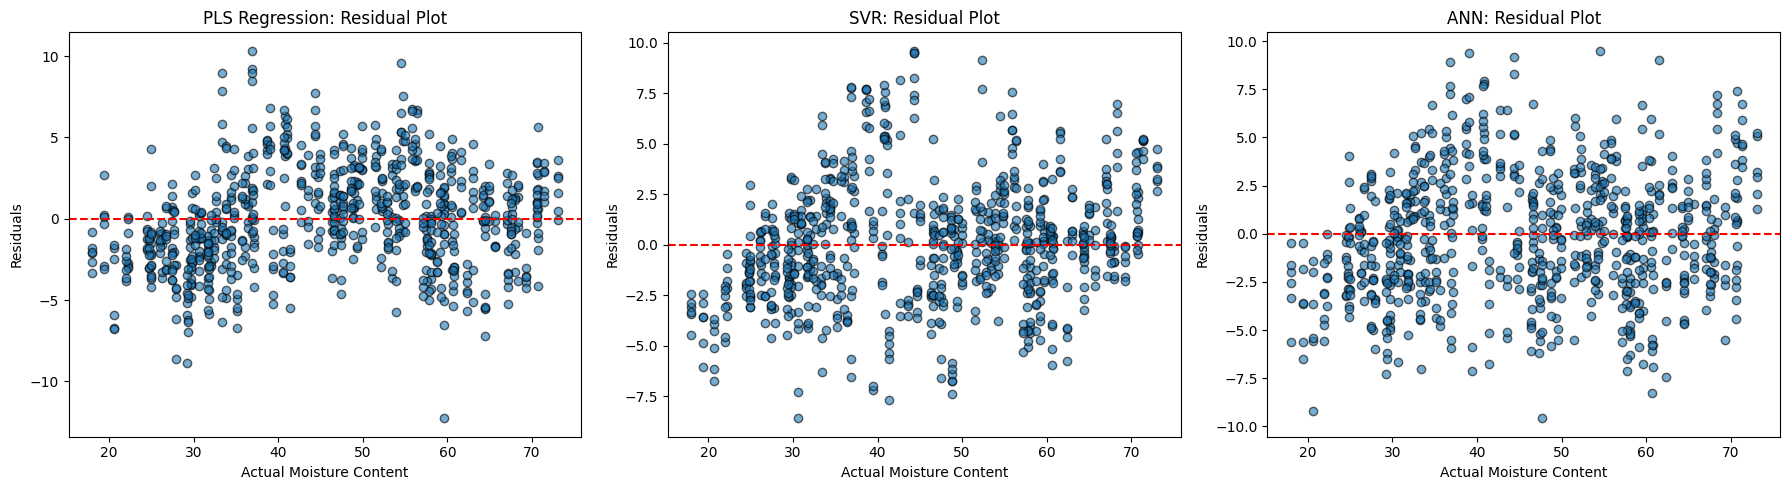

In [ ]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, model, y_pred in zip(axes, models, predictions):
    residuals = y - y_pred
    ax.scatter(y, residuals, alpha=0.6, edgecolors="k")
    ax.axhline(y=0, color="red", linestyle="dashed")  # Reference line
    ax.set_xlabel("Actual Moisture Content")
    ax.set_ylabel("Residuals")
    ax.set_title(f"{model}: Residual Plot")

plt.tight_layout()
plt.show()